# 01. BasicTutorial

In this tutorial, you can learn how to:

* Define Search Space
* Optimize Objective Function

This tutorial describes how to optimize Hyperparameters using UltraOpt without having a mathematical understanding of any algorithm implemented in UltraOpt.

在这个教程中，您将学习到：

* 定义搜索空间
* 优化目标函数

通过这个教程，您无需理解UltraOpt所实现算法的任何数学原理，就可以通过UltraOpt去优化超参数。

In [1]:
# import fmin interface from UltraOpt
from ultraopt import fmin
# hdl2cs can convert HDL(Hyperparams Describe Language) to CS(Config Space)
from ultraopt.hdl import hdl2cs

Declares a purpose function to evaluate. In this tutorial, we will optimize a simple function called `evaluate`, which is a simple quadratic function. It should be noted that in our definition, the evaluation function accepts parameters **config** and returns **loss**. The smaller the loss, the better the config.

声明要优化的评价函数。在本教程中，我们将优化一个名为`evaluate`的简单函数，它是一个简单的二次函数。需要注意的是在我们的定义中，评价函数接受参数返回loss，loss越小表示配置越好。

$$ y = (x-3)^2 + 2 $$

In [2]:
def evaluate(config:dict):
    x = config["x"]
    return (x-3)**2 + 2

Now, let's visualize this objective function.

现在，让我们可视化这个目标函数。

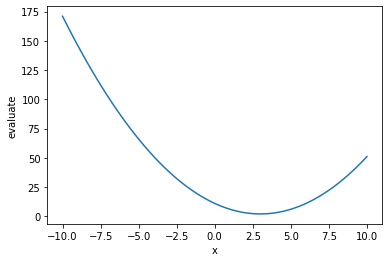

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-10, 10, 100)
y = [evaluate({"x": xi}) for xi in x]

fig = plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("evaluate")
plt.show()

We are trying to optimize the objective function by changing the HyperParameter $x$. That's why we will declare a search space for $x$. The functions related to the search space are implemented in `ultraopt.hdl.hp_def`. The list is as follows.

我们试图通过改变超参数$x$来优化目标函数。这就是为什么我们要声明一个$x$的搜索空间。与搜索空间相关的函数在`ultraopt.hdl.hp_def`中实现. 列举如下。

* `{"_type": "choice", "_value": options}`
* `{"_type": "ordinal", "_value": sequence}`
* `{"_type": "uniform", "_value": [low, high]}`
* `{"_type": "quniform", "_value": [low, high, q]}`
* `{"_type": "loguniform", "_value": [low, high]}`
* `{"_type": "qloguniform", "_value": [low, high, q]}`
* `{"_type": "int_uniform", "_value": [low, high]}`
* `{"_type": "int_quniform", "_value": [low, high, q]}`

HDL(超参描述语言)是一种参考[nni](https://github.com/microsoft/nni)的[搜索空间](https://nni.readthedocs.io/en/stable/Tutorial/SearchSpaceSpec.html?highlight=space)而实现的一种超参数描述方法，UltraOpt通过`ultraopt.hdl.hdl2cs`函数将**HDL**转换成**配置空间**([ConfigSpace](https://github.com/automl/ConfigSpace), 一种在[AutoSklearn](https://github.com/automl/auto-sklearn), [HpBandSter](https://github.com/automl/HpBandSter)等库中大量采用的基础库)

HDL的编写方法为`{"变量名": 超参范围描述, ...}`，本例的HDL如下：

In [4]:
HDL = { 
    "x":{ # 变量名为 x
        "_type": "uniform",  # 变量类型为 uniform 
        "_value": [-10, 10]  # 变量取值范围为 low = -10, hight = 10
    }
}

通过 `ultraopt.hdl.hdl2cs` 函数将HDL转换为CS

In [5]:
CS = hdl2cs(HDL)
CS

Configuration space object:
  Hyperparameters:
    x, Type: UniformFloat, Range: [-10.0, 10.0], Default: 0.0

配置空间CS是具有采样功能的，我们从中随机采5个样本，并将其转换为dict类型

In [13]:
configs = [config.get_dictionary() for config in CS.sample_configuration(5)]
configs

[{'x': 0.7392269862367904},
 {'x': -9.426085697770803},
 {'x': -3.686940811936208},
 {'x': 7.105520078836378},
 {'x': -0.2600865409918569}]

对每个`configs`都调用`objective`函数评估一次，获取其目标值，对于目标值最小的，就是我们想要的最佳配置。

以上步骤其实就是一次最简单的黑箱优化流程。

In [25]:
import numpy as np
losses = [evaluate(config) for config in configs]
best_ix = np.argmin(losses)
print(f"optimal config: {configs[best_ix]}, \noptimal loss: {losses[best_ix]}")

optimal config: {'x': 0.7392269862367904}, 
optimal loss: 7.111094619759985


在学习了**超参空间定义**、**采样**、**评估**等`黑箱优化流程`后，我们希望能够用一个工具将这些步骤串起来，并希望使用启发式的优化算法而不是随机搜索。此时我们可以采用UltraOpt的`fmin`函数，这个函数需要定义4个重要的参数：

|参数名|描述|
|-----|---|
|eval_func|评价函数，接受config参数(`dict`类型)，返回loss。我们希望最好的`config`(配置)具有最小的`loss`|
|config_space | 配置空间，可以传入HDL(`dict`类型)，也可以传入CS(`ConfigSpace`类型)|
|optimizer| 优化器。在使用优化器默认参数的情况下，您只需要指定优化器的名字，列举如下。|
|n_iterations| 迭代次数，在不考虑多保真优化的情况下可视为评价函数执行次数 |

|优化器|描述|
|-----|---|
|ETPE| Embedding-Tree-Parzen-Estimator, 是UltraOpt作者唐麒淳自创的一种优化算法，在TPE算法的基础上对类别变量采用Embedding降维为低维连续变量，并在其他的一些方面也做了改进。ETPE在某些场景下表现比HyperOpt的TPE算法要好。 |
|Forest |基于随机森林的贝叶斯优化算法。|
|GBRT| 基于梯度提升回归树(Gradient Boosting Resgression Tree)的贝叶斯优化算法。 |
|Random| 随机搜索。 |

In [41]:
result = fmin(
    eval_func=evaluate,
    config_space=HDL,
    optimizer="Forest",
    n_iterations=100
)

100%|██████████| 100/100 [00:03<00:00, 25.90trial/s, best loss: 2.000]


In [42]:
result

+---------------------------------+
| HyperParameters | Optimal Value |
+-----------------+---------------+
| x               | 3.0014        |
+-----------------+---------------+
| Optimal Loss    | 2.0000        |
+-----------------+---------------+
| Num Configs     | 100           |
+-----------------+---------------+